# This Notebook is used to demostrate the featured logistic regression
It will include following steps:
* load data
* extract features from data
* use extracted features instead of pixes to train the logistic regression model

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from scipy.ndimage import uniform_filter
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [90]:
with open('../data/notMNIST.pickle', 'rb') as f:
    data_set = pickle.load(f)

In [127]:
train_size = 16000
valid_size = 1000
test_size = 1000
train_dataset = data_set['train_dataset'][:train_size,:,:]
train_label = data_set['train_labels'][:train_size]
valid_dataset = data_set['valid_dataset'][:valid_size,:,:]
valid_label = data_set['valid_labels'][:valid_size]
test_dataset = data_set['test_dataset'][:test_size,:,:]
test_label = data_set['test_labels'][:test_size]
# turn our y label from index in 1 to 10 into array of R1x10 for example turn 2 into [0,0,1,0,0,0,0,0,0,0]

print("train_dataset size:")
print(np.shape(train_dataset))

train_dataset size:
(16000, 28, 28)


In [128]:
def extract_features(imgs):
  num_images = imgs.shape[0]
  if num_images == 0:
    return np.array([])
  feats = hog_feature(imgs[0].squeeze())
  imgs_features = np.zeros((num_images, feats.shape[0]))
  for i in xrange(0, num_images):
    imgs_features[i,:] = hog_feature(imgs[i].squeeze())
  return imgs_features
def hog_feature(image):
  """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """
  
  # convert rgb to grayscale if needed
  sx, sy = image.shape # image size
  orientations = 9 # number of gradient bins
  cx, cy = (4, 4) # pixels per cell
  gx = np.zeros(image.shape)
  gy = np.zeros(image.shape)
  gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
  gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
  grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

  n_cellsx = int(np.floor(sx / cx))  # number of cells in x
  n_cellsy = int(np.floor(sy / cy))  # number of cells in y
  # compute orientations integral images
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
  for i in range(orientations):
    # create new integral image for this orientation
    # isolate orientations in this range
    temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
    temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
    # select magnitudes for those orientations
    cond2 = temp_ori > 0
    temp_mag = np.where(cond2, grad_mag, 0)
    orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[cx/2::cx, cy/2::cy].T
  
  return orientation_histogram.ravel()
def accuracy(predictions, labels):
  print predictions.shape
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])
num_classes = 10
y_train_label = (np.arange(num_classes) == train_label[:,None]).astype(np.int32)
featured_train_dataset = extract_features(train_dataset)
featured_valid_dataset = extract_features(valid_dataset)
featured_test_dataset = extract_features(test_dataset)
num_features = featured_train_dataset.shape[1]

In [129]:
graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.constant(featured_train_dataset, dtype=tf.float32)
  tf_train_labels = tf.constant(y_train_label)
  tf_valid_dataset = tf.constant(featured_valid_dataset, dtype=tf.float32)
  tf_test_dataset = tf.constant(featured_test_dataset, dtype=tf.float32)
  
    
  weights = tf.Variable(
    tf.truncated_normal([num_features, num_classes]), dtype=tf.float32)
  biases = tf.Variable(tf.zeros([num_classes]))
  
  logits = tf.matmul(tf_train_dataset, weights) + biases
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  optimizer = tf.train.GradientDescentOptimizer(10).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [130]:
num_steps = 801


with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  print()
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    
    if (step % 200 == 0):
      print('Loss at step %d: %f' % (step, l))
      print predictions.shape[0]
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_label))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%\n' % accuracy(
        valid_prediction.eval(), valid_label))

# print the accuracy of our model.
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
()
Loss at step 0: 2.489006
16000
(16000, 10)
Training accuracy: 9.1%
(1000, 10)
Validation accuracy: 11.5%

Loss at step 200: 0.802565
16000
(16000, 10)
Training accuracy: 78.9%
(1000, 10)
Validation accuracy: 80.2%

Loss at step 400: 0.693159
16000
(16000, 10)
Training accuracy: 81.5%
(1000, 10)
Validation accuracy: 82.2%

Loss at step 600: 0.645074
16000
(16000, 10)
Training accuracy: 82.4%
(1000, 10)
Validation accuracy: 83.7%

Loss at step 800: 0.615777
16000
(16000, 10)
Training accuracy: 83.2%
(1000, 10)
Validation accuracy: 84.2%

(1000, 10)
Test accuracy: 89.0%


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: operands could not be broadcast together with shapes (28,28) (7,7) (28,28) 

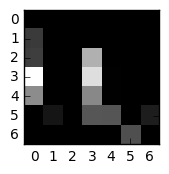

In [131]:
# for(i in np.arrange(10)):
#     plt.subplot(i, 0)
#     plt.imshow(featured_train_dataset[i].astype('uint8'))
#     plt.axis('off')
#         if i == 0:
#             plt.title(cls_name)
# plt.show()
num_feature_size = featured_train_dataset.shape[1]
orientations = 9
size = np.sqrt(num_feature_size / 9)
image = featured_train_dataset[0,:].reshape(size,size,orientations)
temp = np.zeros((28,28))
for i in np.arange(orientations):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[:,:,i])
    temp += image[:,:,i]
plt.subplot(4, 4, 10)
plt.imshow(np.array(train_dataset[0] > 0))
plt.show()
plt.subplot(4, 4, 10)
plt.imshow(np.array(temp > 0, dtype=np.int32))
plt.show()